| <p style="text-align: left;">Name</p>               | Matr.Nr. | <p style="text-align: right;">Date</p> |
| --------------------------------------------------- | -------- | ------------------------------------- |
| <p style="text-align: left">Lion DUNGL</p> | 01553060 | 09.02.2020                            |

<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 7 (Assignment) -- Generative models II </h2>

Authors: Brandstetter, Schäfl<br>
Date: 20-01-2020

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies 
to all code within this file.

Copyright statement: <br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

# Exercise 0
Before tackling all those exciting tasks of this notebook, the neccessary Python modules need to be loaded. Have a look at the notebook discussed during the lecture, and import the following modules/symbols:

- <code>u7_utils</code>
- <code>matplotlib.pyplot</code>
- <code>matplotlib.image</code>
- <code>numpy</code>
- <code>os</code>
- <code>torch</code>
- <code>torch.autograd.Variable</code>
- <code>types.SimpleNamespace</code>
- <code>typing.Tuple</code>

### Important note!
As the <code>torchvision</code> module used to load data sets does <i>not</i> support version $7$ of the <code>PIL</code> module, ensure that the installed version of your Python environment is from the series $6$. If you are using <i>Anaconda</i> (or <i>Miniconda</i>), you can install the correct version via <code>conda install Pillow==6.2</code>.

In [1]:
try:
    from PIL import __version__
except:
    from PIL import PILLOW_VERSION as __version__

print(r'The installed Pillow version is: {}'.format(__version__))

The installed Pillow version is: 5.4.1


In [2]:
import u7_utils as u7
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch
from torch.autograd import Variable
from types import SimpleNamespace
from typing import Tuple

Afterwards, check if the <code>torch</code> module was correctly imported, by computing the <i>cumprod</i> of <code>[7, 2, 4, 9]</code> and printing the result. Moreover, check the version of your <i>PyTorch</i> installation (in case of problems with different Python modules, it is <i>always</i> a good idea to include their <i>version numbers</i> to help others giving a more specific support).

In [3]:
torch.cumprod(torch.as_tensor([7, 2, 4, 9], dtype=torch.float32), dim=0)

tensor([  7.,  14.,  56., 504.])

In [4]:
torch.__version__

'1.3.1'

As all plots <i>created</i> in this assignment are <i>stored</i> in a specific <i>directory</i>, create a <i>subdirectory</i> termed <code>samples</code> in the current working directory.

In [5]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))

# Exercise 1
<font color='darkred'><i>Note: this exercise is pretty similar to <b>Exercise 1</b> of the previous assignment. The reason for this is a simple one: if you are working with a new data set, <b>always</b> get your hands dirty by digging into the structure of the data set itself, visualize different features, try to get a feeling about the data you are working with. Blindly applying methods of Machine Learning to unkown data most often leads to frustrating results.</i></font>

Before loading any <i>data set</i> or defining any <i>neural network</i>, some hyperparameters used throughout this assignment should be set (some entries might be <i>reset</i> in the course of some tasks). Hence, for the <b>first task</b> of this exercise, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters accordingly:

- <code>batch_size = 64</code>
- <code>test_batch_size = 1000</code>
- <code>epochs = 5</code>
- <code>lr = 0.001</code>
- <code>weight_decay = 0.00005</code>

The field <code>log_interval</code> can be chosen freely as well as the <i>device</i> on which to compute.

In [296]:
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=5, lr=0.001, 
                       weight_decay=0.00005, log_interval=100)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In this exercise you will be working with a data set composed of various <i>images</i> of different kinds of entities (like <i>dogs</i> or <i>ships</i>). For curious minds, more information regarding this data set can be found at (maybe it looks already familiar to you):

<cite>Krizhevsky, A. and Hinton, G., 2009. Learning multiple layers of features from tiny images (Vol. 1, No. 4, p. 7). Technical report, University of Toronto.</cite>

Moreover, perform the following steps prior to unleashing your cumulated knowledge about <i>machine learning</i> on the data:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Load the <i>CIFAR10</i> data set (returns the <i>training</i> as well as the <i>test</i> set data loader).
- Display the first <i>36</i> images of the <i>CIFAR10</i> data set.

Can you identify possible <i>labels</i> of the displayed images?

Files already downloaded and verified
Files already downloaded and verified


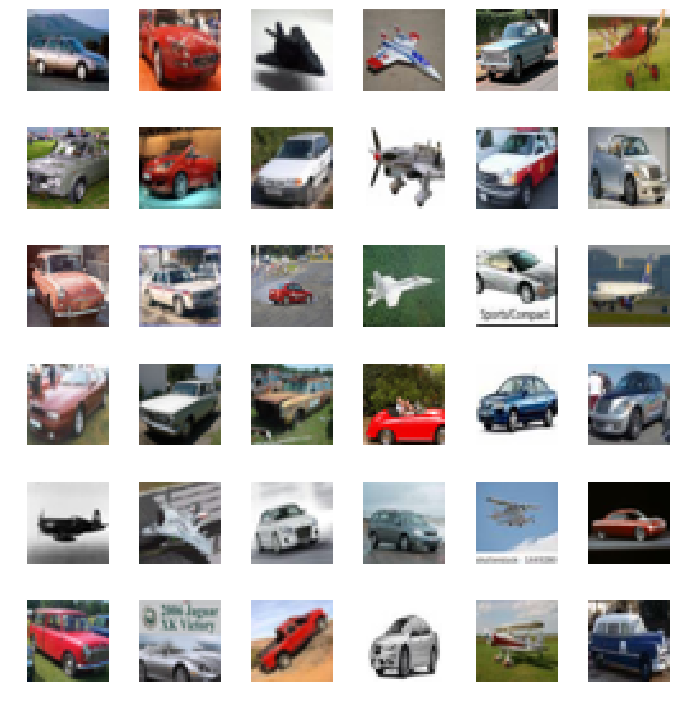

In [7]:
torch.manual_seed(42)
train_loader, test_loader = u7.get_CIFAR10_data(args, use_cuda)
u7.display_CIFAR10(train_loader, 36)

In order to define any <i>generative</i> neural network (e.g. <i>autoencoders</i> and their various variants) for further processing of the data set, some minimal knowledge about the <i>structure</i> of the images is required:

- Find out the <i>input dimensionality</i> of the data set.

Keep in mind, that images of the CIFAR10 data set are pretty <i>colorful</i>.

In [8]:
train_image_zero, train_target_zero = train_loader.dataset[0]
input_dim = train_image_zero.shape[0] * train_image_zero.shape[1] * train_image_zero.shape[2]
print("The input dimensionality is", input_dim)

The input dimensionality is 3072


More information about the classes and the corresponding target <i>name</i> as well as sample depictions can be found in the following table (images taken from <cite>https://www.cs.toronto.edu/~kriz/cifar.html</cite> and directly embedded, hence an <i>Internet</i> connection is required to load them – only the first <i>two</i> classes are used in this assignment):



As <i>autoencoders</i> (and their variants) are very handy tools for <i>projecting</i> data sets <i>down</i> to a specific dimensionality (often termed <i>compression</i>), a comparison to other established methods is appropriate. For this very purpose, recall your knowledge about <i>dimensionality reduction techniques</i> and perform the following steps as your <b>second task</b> of this exercise:

- Apply <i>PCA</i> on the first $n = 972$ entries and project the CIFAR10 data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

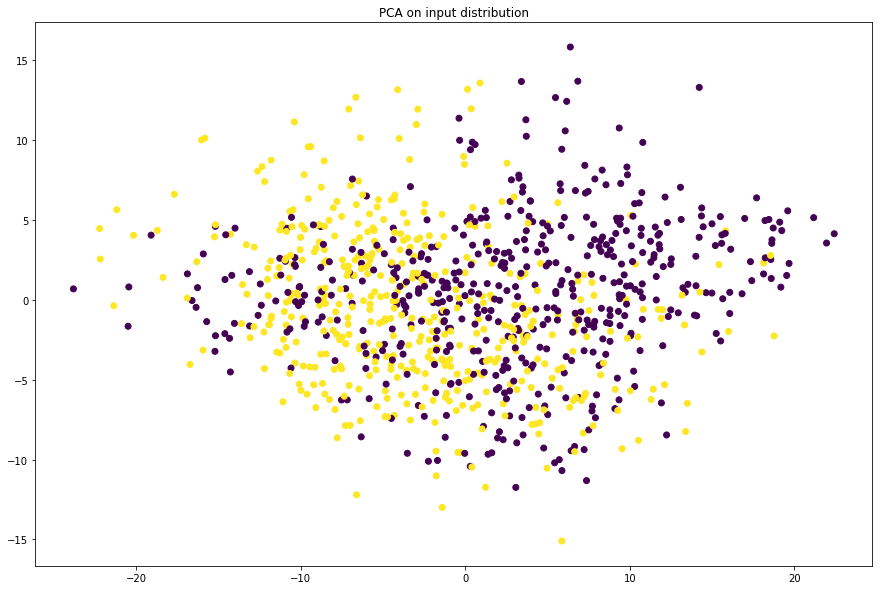

In [9]:
u7.plot_PCA(train_loader, 'PCA on input distribution', 972)

# AttributeError is also occuring in my lesson-notebook. Since the plot seems to be correct and the error
# just seems to be regarding the plotting, I didn't try to get rid of it.

<i>Principal component analysis</i> is not the only dimensionality reduction technique presented in this course, so to extend the <b>second task</b> of this exercise, further recall your knowledge about this topic (or have a glimpse at the notebooks of the lecture) and perform the following steps:

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the first $n = 972$ entries and project the CIFAR10 data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

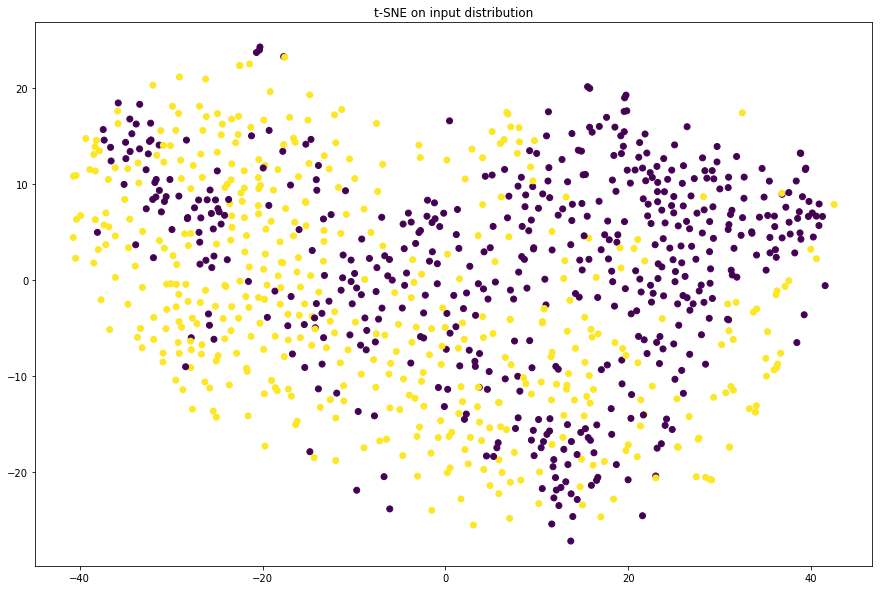

In [10]:
np.random.seed(42)
u7.plot_tsne(train_loader, 't-SNE on input distribution', 972)

# Exercise 2
<font color='darkred'><i>Note: the tasks of this exercise will consume <b>a lot</b> of computational resources, and thus will take some time to complete (most probably $\gt 20min$). This is especially the case if <b>no</b> NVIDIA GPU is available. As the final quality of the generated images is highly dependent on the available resources and time spent training the networks, your final points of this exercise will <b>not</b> depend on the image quality but on correctness of the implementation and interpretation of the results.</i></font>

As of <b>Exercise 3</b> of the last assignment, you are already pretty familiar with <i>variational autoencoders</i> and their ability to generate samples from <i>random</i> initial data. As we are again working with images (or more generally, data with <i>structural dependencies</i> between neighboring <i>features</i>), <i>convolutional neural networks (CNNs)</i> seem to be a great fit in order to <i>analyze</i> and <i>transform</i> the data set.

So your <b>first</b> task of this exercise is to combine both methods, <i>variational autoencoders</i> and <i>convolutional neural networks</i>. Thus, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters and further members accordingly $\ldots$

$\ldots$ for the <i>input convolution</i>:
- <code>in_channels = 3</code>
- <code>projection_channels = 32</code>
- <code>input_kernel_size = 3</code>

$\ldots$ for the <i>input pooling</i>:
- <code>input_pool_kernel_size = 2</code>
- <code>input_pool_stride = 2</code>

$\ldots$ for the <i>hidden convolution</i> and <i>mean/covariance projection</i>:
- <code>hidden_channels = 48</code>
- <code>hidden_kernel_size = 3</code>
- <code>input_width = 32</code>
- <code>input_height = 32</code>

$\ldots$ for the <i>hidden pooling</i>:
- <code>hidden_pool_kernel_size = 2</code>
- <code>hidden_pool_stride = 2</code>

Further fields like <code>batch_size</code> or <code>weight_decay</code> can be reused from <b>Exercise 1</b>.

In [9]:
settings = SimpleNamespace(
    
    # Settings of the input convolution.
    input_channels=3, projection_channels=32, input_kernel_size=3,
    
    # Settings of the input pooling.
    input_pool_kernel_size=2, input_pool_stride=2,
    
    # Settings for the hidden convolution and mean/covariance projection.
    hidden_channels=48, hidden_kernel_size=3, input_width=32, input_height=32,
    
    # Settings of the hidden pooling.
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)

On the basis of the <i>convolutional neural network</i> and <i>variational autoencoder</i> implementations of the lecture, construct a <i>convolutional variational autoencoder</i> using the <i>settings</i> defined up above and the following attributes (to get you started, later on you are encouraged to modify some of these settings in order to get more interesting results, but keep in mind, that <i>recklessly</i> setting some hyperparameters to <i>big</i> numbers most probably leads to <i>enormous</i> runtimes) for $\ldots$

$\ldots$ for the <i>encoder</i> network:
- One <i>convolutional</i> input layer, accepting images of the <i>CIFAR10</i> data set.
- One <i>max pooling</i> layer, operating on the result of the <i>input</i> layer.
- One <i>convolutional</i> hidden layer, with an output dimensionality as defined previously.
- One <i>max pooling</i> layer, operating on the result of the <i>hidden</i> layer.
- Two <i>dense</i> encoder layers, with a dimensionality as defined by <code>hidden_channels</code>.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the decoder output).

$\ldots$ for the <i>decoder</i> network:
- One <i>dense</i> decoder layer, accepting images of the <i>CIFAR10</i> data set, as encoded by the <i>encoder</i> network.
- Two <i>upconvolution</i> layers, effectively transforming the result of the previous layer back to the <i>input</i> space.

To summarize your <b>second task</b> of this exercise:

- Implement a <i>Python class</i> <code>ConvolutionalVAE</code> as discussed during the lexture.
- Implement a <i>utility Python class</i> <code>Inflate</code>, which acts as a negation to <code>Flatten</code>.

In [10]:
data = torch.Tensor(train_loader.dataset.dataset.data)
data.size()

torch.Size([50000, 32, 32, 3])

In [10]:
# Conv1: (3, 32, 32) --> (3, 34, 34) (padding) --> (32, 32, 32)
# Pooling 1: --> (32, 16, 16)
# Conv2: --> (32, 18, 18) (padding) --> (48, 16, 16)
# Pooling 2: --> (48, 8, 8)
# Flatten: --> (48, 8*8)

# Inflate: --> (48, 8, 8)
# 

class Inflate(torch.nn.Module):
    
    def __init__(self, dimensionality: int, output_width: int, output_height: int):
        super(Inflate, self).__init__()
        self.__dimensionality = dimensionality
        self.output_width = output_width
        self.output_height = output_height
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.view(x.size(0), self.__dimensionality, self.output_width, self.output_height)

    
class ConvolutionalVAE(torch.nn.Module):
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalVAE, self).__init__()
        
        # Input transformation.
        
        input_convolution = torch.nn.Conv2d(settings.input_channels, 
                                            settings.projection_channels, 
                                            settings.input_kernel_size, padding=1)
        
        output_width = self._compute_convolution_size(size=settings.input_width, 
                                                     kernel_size=settings.input_kernel_size, padding=1)
        output_height = self._compute_convolution_size(size=settings.input_height, 
                                                     kernel_size=settings.input_kernel_size, padding=1)
        
        input_pool = torch.nn.MaxPool2d(settings.input_pool_kernel_size, 
                                        settings.input_pool_stride)
        
        output_width = int(output_width / settings.input_pool_kernel_size)
        output_height = int(output_height / settings.input_pool_kernel_size)
        
        # Hidden transformation.
        
        hidden_convolution = torch.nn.Conv2d(settings.projection_channels, 
                                             settings.hidden_channels, 
                                             settings.hidden_kernel_size, padding=1)
    
        output_width = self._compute_convolution_size(size=output_width, 
                                                     kernel_size=settings.hidden_kernel_size, padding=1)
        output_height = self._compute_convolution_size(size=output_height, 
                                                     kernel_size=settings.hidden_kernel_size, padding=1)
        
        hidden_pool = torch.nn.MaxPool2d(settings.hidden_pool_kernel_size, 
                                         settings.hidden_pool_stride)
        
        output_width = int(output_width / settings.hidden_pool_kernel_size)
        output_height = int(output_height / settings.hidden_pool_kernel_size)
        
        # Combine encoder part.
        
        self.encoder = torch.nn.Sequential(
            input_convolution, torch.nn.ReLU(), input_pool,
            hidden_convolution, torch.nn.ReLU(), hidden_pool, torch.nn.Flatten()
        )
        
        
        # Mean and covariance projections.
        
        self.fc11 = torch.nn.Linear(settings.hidden_channels*output_width*output_height, settings.hidden_channels)
        self.fc12 = torch.nn.Linear(settings.hidden_channels*output_width*output_height, settings.hidden_channels)
        
        
        # Project from latent space to hidden space of decoder.
        
        latent_projection = torch.nn.Linear(settings.hidden_channels, 
                                            settings.hidden_channels*output_width*output_height)
        
        latent_convolution = torch.nn.ConvTranspose2d(settings.hidden_channels, 
                                                      settings.projection_channels, 2, 
                                                      stride=2)
        
        output_convolution = torch.nn.ConvTranspose2d(settings.projection_channels, 
                                                      settings.input_channels, 2, stride=2)
        
        # Combine decoder part.
        
        self.decoder = torch.nn.Sequential(
            latent_projection, Inflate(settings.hidden_channels, output_width, output_height),
            latent_convolution, torch.nn.ReLU(), output_convolution, torch.nn.Sigmoid())
    
    @staticmethod
    def _compute_convolution_size(size: int, padding: int, kernel_size: int, 
                                  dilation: int = 1, stride: int = 1) -> int:
        kernel_size_dilated = dilation * (kernel_size + 1) - 1
        output_size = ((size - kernel_size_dilated + 2 * padding) / stride) + 1
        return int(output_size)
    
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.encoder(x)
        return self.fc11(x), self.fc12(x)
    
    def decode(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(x)
    
    def sample(self, mean: torch.Tensor, covariance: torch.Tensor) -> torch.Tensor:
        if self.training:
            std = torch.exp(0.5*covariance)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x: torch.Tensor) -> Tuple[
            torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        mean, covariance = self.encode(x) 
        x = self.sample(mean, covariance) 
        return self.decode(x), mean, covariance, x

Train the previously defined <i>convolutional variational autoencoder</i> model by applying the corresponding <i>data loader</i> (keep in mind for which data set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>.

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.

Report the performance on the <i>test set</i> afterwards. Moreover, experiment with different hyperparameter settings, for instance set different values for $\ldots$

- $\ldots$ the learning rate <code>lr</code>.
- $\ldots$ the hidden dimensionality <code>hidden_channels</code>.
- $\ldots$ the size of the input kernel <code>input_kernel_size</code>.

Do you notice any differences? With respect to runtime, which <i>settings</i> had a small/big impact? Try to argue about <i>possible</i> reasons.

In [11]:
model = ConvolutionalVAE(settings).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

for epoch in range(1, args.epochs + 1):
    u7.train_conv_variational_autoencoder(args, model, device, train_loader, input_dim, 
                                          optimizer, epoch)
    u7.test_conv_variational_autoencoder(args, model, device, test_loader, input_dim)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137018.171875
Train Epoch: 1 [6400/10000 (64%)]	Loss: 116184.859375

Test set loss: 1859357.1250
Train Epoch: 2 [0/10000 (0%)]	Loss: 121498.078125
Train Epoch: 2 [6400/10000 (64%)]	Loss: 119799.164062

Test set loss: 1825599.6250
Train Epoch: 3 [0/10000 (0%)]	Loss: 117313.007812
Train Epoch: 3 [6400/10000 (64%)]	Loss: 117423.546875

Test set loss: 1799331.0625
Train Epoch: 4 [0/10000 (0%)]	Loss: 116729.437500
Train Epoch: 4 [6400/10000 (64%)]	Loss: 114891.570312

Test set loss: 1787180.9375
Train Epoch: 5 [0/10000 (0%)]	Loss: 115211.312500
Train Epoch: 5 [6400/10000 (64%)]	Loss: 117327.531250

Test set loss: 1782843.8125


In [43]:
def training(args=args, settings=settings):
    model = ConvolutionalVAE(settings).to(device)
    optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    
    for epoch in range(1, args.epochs + 1):
        u7.train_conv_variational_autoencoder(args, model, device, train_loader, input_dim, 
                                          optimizer, epoch)
        u7.test_conv_variational_autoencoder(args, model, device, test_loader, input_dim)
    
    return model

def visualize(model, settings=settings):
    sample_random = Variable(torch.randn(args.batch_size, settings.hidden_channels)).to(device)
    output = model.decode(sample_random).to(device)
    u7.save_image(output.view(args.batch_size, 3, 32, 32),
                   './samples/vae_random_sample.png')
    img_vae_random = mpimg.imread('./samples/vae_random_sample.png')
    plt.imshow(img_vae_random)

In [15]:
# lr = 0.0000000001

args0_01 = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=5, lr=0.0000000001, 
                       weight_decay=0.00005, log_interval=100)
model0_01 = training(args0_01)

Train Epoch: 1 [0/10000 (0%)]	Loss: 136907.109375
Train Epoch: 1 [6400/10000 (64%)]	Loss: 137339.156250

Test set loss: 2151088.2500
Train Epoch: 2 [0/10000 (0%)]	Loss: 137243.468750
Train Epoch: 2 [6400/10000 (64%)]	Loss: 137124.828125

Test set loss: 2149416.1250
Train Epoch: 3 [0/10000 (0%)]	Loss: 136750.718750
Train Epoch: 3 [6400/10000 (64%)]	Loss: 136912.203125

Test set loss: 2150383.1250
Train Epoch: 4 [0/10000 (0%)]	Loss: 137708.953125
Train Epoch: 4 [6400/10000 (64%)]	Loss: 136230.578125

Test set loss: 2149867.0000
Train Epoch: 5 [0/10000 (0%)]	Loss: 136919.812500
Train Epoch: 5 [6400/10000 (64%)]	Loss: 137095.781250

Test set loss: 2149112.1250


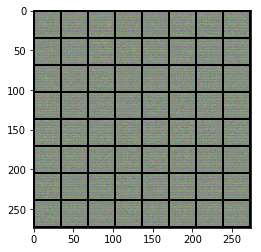

In [16]:
visualize(model0_01)

In [18]:
# lr = 0.01

args0_02 = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=5, lr=0.01, 
                       weight_decay=0.00005, log_interval=100)
model0_02 = training(args0_02)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137493.234375
Train Epoch: 1 [6400/10000 (64%)]	Loss: 121587.812500

Test set loss: 1860372.0625
Train Epoch: 2 [0/10000 (0%)]	Loss: 118723.867188
Train Epoch: 2 [6400/10000 (64%)]	Loss: 116620.906250

Test set loss: 1839107.6875
Train Epoch: 3 [0/10000 (0%)]	Loss: 114658.664062
Train Epoch: 3 [6400/10000 (64%)]	Loss: 115146.031250

Test set loss: 1815759.8750
Train Epoch: 4 [0/10000 (0%)]	Loss: 116973.562500
Train Epoch: 4 [6400/10000 (64%)]	Loss: 121616.843750

Test set loss: 1807074.3125
Train Epoch: 5 [0/10000 (0%)]	Loss: 113982.640625
Train Epoch: 5 [6400/10000 (64%)]	Loss: 114484.046875

Test set loss: 1798773.8750


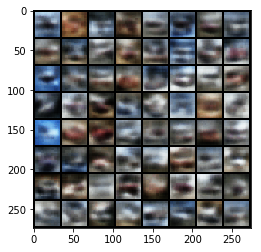

In [20]:
visualize(model0_02)

In [38]:
# lr = 0.18

args0_03 = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=5, lr=0.18, 
                       weight_decay=0.00005, log_interval=100)
model0_03 = training(args0_03)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137629.515625
Train Epoch: 1 [6400/10000 (64%)]	Loss: 139468.218750

Test set loss: 2209593.5000
Train Epoch: 2 [0/10000 (0%)]	Loss: 137694.484375
Train Epoch: 2 [6400/10000 (64%)]	Loss: 137075.031250

Test set loss: 2150472.3750
Train Epoch: 3 [0/10000 (0%)]	Loss: 136872.781250
Train Epoch: 3 [6400/10000 (64%)]	Loss: 136784.109375

Test set loss: 2158404.0000
Train Epoch: 4 [0/10000 (0%)]	Loss: 137407.515625
Train Epoch: 4 [6400/10000 (64%)]	Loss: 136917.000000

Test set loss: 2145104.5000
Train Epoch: 5 [0/10000 (0%)]	Loss: 137028.906250
Train Epoch: 5 [6400/10000 (64%)]	Loss: 137391.921875

Test set loss: 2168599.1250


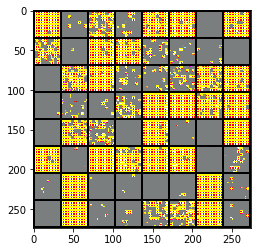

In [39]:
visualize(model0_03)

In [40]:
# hidden_channels = 1

settings0_04 = SimpleNamespace(
    input_channels=3, projection_channels=32, input_kernel_size=3,
    input_pool_kernel_size=2, input_pool_stride=2,
    hidden_channels=1, hidden_kernel_size=3, input_width=32, input_height=32,
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)
model0_04 = training(settings=settings0_04)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137725.546875
Train Epoch: 1 [6400/10000 (64%)]	Loss: 136342.468750

Test set loss: 2157504.7500
Train Epoch: 2 [0/10000 (0%)]	Loss: 136287.187500
Train Epoch: 2 [6400/10000 (64%)]	Loss: 133905.750000

Test set loss: 2060738.2500
Train Epoch: 3 [0/10000 (0%)]	Loss: 131746.750000
Train Epoch: 3 [6400/10000 (64%)]	Loss: 130244.750000

Test set loss: 2004264.1875
Train Epoch: 4 [0/10000 (0%)]	Loss: 126453.796875
Train Epoch: 4 [6400/10000 (64%)]	Loss: 126580.382812

Test set loss: 1991464.3750
Train Epoch: 5 [0/10000 (0%)]	Loss: 130564.468750
Train Epoch: 5 [6400/10000 (64%)]	Loss: 125272.421875

Test set loss: 1986210.4375


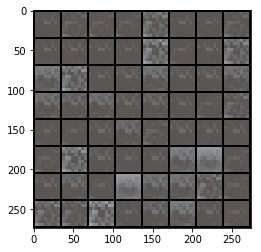

In [44]:
visualize(model0_04, settings0_04)

In [45]:
# hidden_channels = 20

settings0_05 = SimpleNamespace(
    input_channels=3, projection_channels=32, input_kernel_size=3,
    input_pool_kernel_size=2, input_pool_stride=2,
    hidden_channels=20, hidden_kernel_size=3, input_width=32, input_height=32,
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)
model0_05 = training(settings=settings0_05)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137882.437500
Train Epoch: 1 [6400/10000 (64%)]	Loss: 123124.593750

Test set loss: 1891618.6875
Train Epoch: 2 [0/10000 (0%)]	Loss: 121043.507812
Train Epoch: 2 [6400/10000 (64%)]	Loss: 119883.632812

Test set loss: 1848165.5625
Train Epoch: 3 [0/10000 (0%)]	Loss: 120088.179688
Train Epoch: 3 [6400/10000 (64%)]	Loss: 118143.343750

Test set loss: 1833737.1875
Train Epoch: 4 [0/10000 (0%)]	Loss: 117518.164062
Train Epoch: 4 [6400/10000 (64%)]	Loss: 120477.867188

Test set loss: 1834260.0625
Train Epoch: 5 [0/10000 (0%)]	Loss: 116521.414062
Train Epoch: 5 [6400/10000 (64%)]	Loss: 119694.750000

Test set loss: 1816032.3125


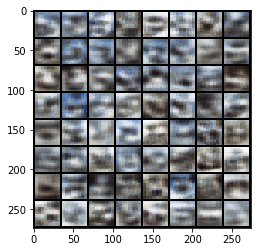

In [46]:
visualize(model0_05, settings0_05)

In [47]:
# hidden_channels = 500

settings0_06 = SimpleNamespace(
    input_channels=3, projection_channels=32, input_kernel_size=3,
    input_pool_kernel_size=2, input_pool_stride=2,
    hidden_channels=500, hidden_kernel_size=3, input_width=32, input_height=32,
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)
model0_06 = training(settings=settings0_06)

Train Epoch: 1 [0/10000 (0%)]	Loss: 140819.968750
Train Epoch: 1 [6400/10000 (64%)]	Loss: 121290.421875

Test set loss: 1853284.5000
Train Epoch: 2 [0/10000 (0%)]	Loss: 122151.984375
Train Epoch: 2 [6400/10000 (64%)]	Loss: 119835.265625

Test set loss: 1821347.5000
Train Epoch: 3 [0/10000 (0%)]	Loss: 116567.453125
Train Epoch: 3 [6400/10000 (64%)]	Loss: 114627.312500

Test set loss: 1807692.7500
Train Epoch: 4 [0/10000 (0%)]	Loss: 119138.351562
Train Epoch: 4 [6400/10000 (64%)]	Loss: 118222.484375

Test set loss: 1799867.8125
Train Epoch: 5 [0/10000 (0%)]	Loss: 115358.375000
Train Epoch: 5 [6400/10000 (64%)]	Loss: 114871.195312

Test set loss: 1793416.3750


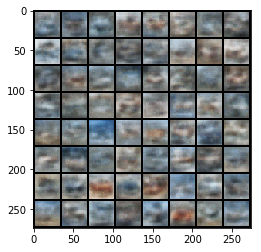

In [48]:
visualize(model0_06, settings0_06)

In [58]:
# input_kernel_size = 1

settings0_07 = SimpleNamespace(
    input_channels=3, projection_channels=32, input_kernel_size=1,
    input_pool_kernel_size=2, input_pool_stride=2,
    hidden_channels=48, hidden_kernel_size=3, input_width=32, input_height=32,
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)
model0_07 = training(settings=settings0_07)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137802.953125
Train Epoch: 1 [6400/10000 (64%)]	Loss: 120718.593750

Test set loss: 1872391.6875
Train Epoch: 2 [0/10000 (0%)]	Loss: 122671.078125
Train Epoch: 2 [6400/10000 (64%)]	Loss: 118976.890625

Test set loss: 1838876.1250
Train Epoch: 3 [0/10000 (0%)]	Loss: 116928.046875
Train Epoch: 3 [6400/10000 (64%)]	Loss: 118099.460938

Test set loss: 1814557.0000
Train Epoch: 4 [0/10000 (0%)]	Loss: 119482.875000
Train Epoch: 4 [6400/10000 (64%)]	Loss: 119426.679688

Test set loss: 1804077.6250
Train Epoch: 5 [0/10000 (0%)]	Loss: 117066.953125
Train Epoch: 5 [6400/10000 (64%)]	Loss: 116644.898438

Test set loss: 1796796.1250


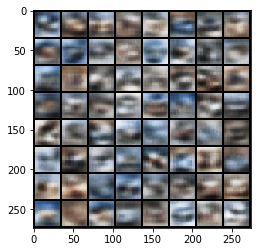

In [59]:
visualize(model0_07)

In [88]:
# input_kernel_size = 2

settings0_08 = SimpleNamespace(
    input_channels=3, projection_channels=32, input_kernel_size=2,
    input_pool_kernel_size=2, input_pool_stride=2,
    hidden_channels=48, hidden_kernel_size=3, input_width=32, input_height=32,
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)
model0_08 = training(settings=settings0_08)

Train Epoch: 1 [0/10000 (0%)]	Loss: 137920.812500
Train Epoch: 1 [6400/10000 (64%)]	Loss: 120638.015625

Test set loss: 1867603.8125
Train Epoch: 2 [0/10000 (0%)]	Loss: 116210.804688
Train Epoch: 2 [6400/10000 (64%)]	Loss: 119959.460938

Test set loss: 1829828.4375
Train Epoch: 3 [0/10000 (0%)]	Loss: 117888.398438
Train Epoch: 3 [6400/10000 (64%)]	Loss: 114749.929688

Test set loss: 1809633.3125
Train Epoch: 4 [0/10000 (0%)]	Loss: 118571.015625
Train Epoch: 4 [6400/10000 (64%)]	Loss: 119414.328125

Test set loss: 1799686.5000
Train Epoch: 5 [0/10000 (0%)]	Loss: 119588.273438
Train Epoch: 5 [6400/10000 (64%)]	Loss: 117192.375000

Test set loss: 1789919.1250


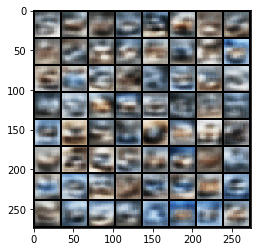

In [89]:
visualize(model0_08)

# Answer
## Differences with respect to runtime
- The more hidden channels there are, the longer it takes to train the model.
- Except for this case, all the other settings lead to a more or less same runtime.

## Differences with respect to the loss
- The greates loss with respect to different learning rates can be observed with a very low or a very high learning rate. The optimum lies in between.
- The more hidden channels are used, the lower is the loss, because less information gets lost when passing the bottleneck.

## Differences with respect to the decoded latent representation
- A very low learning rate resulted in just grey pictures. This is because in this case, no actual training is happening.
- A very high learning rate leads to more or less random pictures. In this case, the weights of the neural network are jumping around randomly over the course of the epochs.
- Only one hidden channel leads to images that are nearly just grey. Here, nearly all the information gets lost when the images are passed through the bottleneck.
- With a few more channels more and more is recognisable, but the resulting images are nearly black or white. This lets one conclude that the color information gets lost.
- With very many hidden channels, the resulting images are getting a little bit crispy.
- It seems like a slightly bigger kernel leads to a little bit better resulting images.

In the previous exercise, PCA was applied on the <i>input space</i> of the reduced CIFAR10 data set. As a <i>convolutional variational autoencoder</i> model was trained in the meantime, it would be interesting and eventually insightful to analyze the <i>hidden</i> or <i>latent representation</i> of said data set with respect to a distinction between the corresponding <i>targets/classes</i>. The <b>third task</b> of this exercise consists of the following steps:

- Apply <i>PCA</i> on the <i>latent representation</i> of the first $n = 972$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i> (argument <code>input_dim</code> must be of the same shape as an original image of the data set – additionally, the field <code>index</code> has to be $-1$).

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

In [90]:
u7.plot_PCA_hidden(model, train_loader, device, input_dim, 'PCA on hidden representation', 972, -1)

# same error occurs when I am trying to use this function with the "conv_VAE" from the lesson

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 32 3 3 3, but got 2-dimensional input of size [972, 3072] instead

In [88]:
# Attempt to fix the error

def inflate(x: torch.Tensor) -> torch.Tensor:
    return x.view(972, 3, -1, 8)

def plot_PCA_hidden_conv(model, data_loader, device, input_dim, title, nr_datapoints, index: int = 0):
    dimensionality = torch.prod(torch.as_tensor(data_loader.dataset[0][0].shape)).item()
    data = torch.stack(
        [data_loader.dataset[_][0] for _ in range(nr_datapoints)]
    ).to(dtype=torch.float32)
    data = data.view(-1, *input_dim if isinstance(input_dim, u7.Iterable) else [input_dim])
    data = inflate(data)
    target = torch.as_tensor(
        [data_loader.dataset[_][1] for _ in range(nr_datapoints)],
        dtype=torch.int32)
    color = target.cpu().numpy()
    if index is None:
        hidden = model(data)
    else:
        hidden = model(data)[index]
    hidden_PCA = u7.PCA(hidden)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(title)
    im = ax.scatter(hidden_PCA[:, 0].detach().cpu().numpy(), hidden_PCA[:, 1].detach().cpu().numpy(), c=color)
    legend = ax.legend(*im.legend_elements(), loc=r'upper right', title=r'Class')
    ax.add_artist(legend)
    plt.show()

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

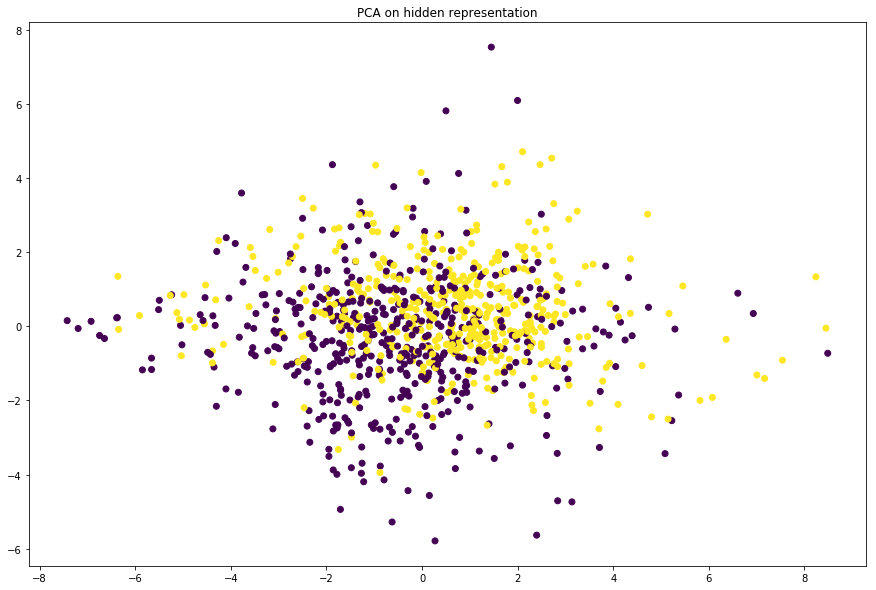

In [89]:
plot_PCA_hidden_conv(model, train_loader, device, input_dim, 'PCA on hidden representation', 972, -1)

As the results of <i>principal component analysis</i> and <i>t-distributed neighbor embedding</i> might vary a lot, an <i>analysis</i> of the <i>hidden space</i> of your trained <i>convolutional variational autoencoder</i> model on the basis of <i>t-SNE</i> would be very interesting.

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the <i>latent representation</i> of the first $n = 972$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i> (argument <code>input_dim</code> must be of the same shape as an original image of the data set – additionally, the field <code>index</code> has to be $-1$).

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

In [91]:
u7.plot_tsne_hidden(model, train_loader, device, input_dim, 't-SNE on hidden representation', 972, -1)

# same error occurs when I am trying to use this function with the "conv_VAE" from the lesson

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 32 3 3 3, but got 2-dimensional input of size [972, 3072] instead

In [94]:
# Attempt to fix the error

def plot_tsne_hidden_conv(model, data_loader, device, input_dim, title, nr_datapoints, index: int = 0):
    dimensionality = torch.prod(torch.as_tensor(data_loader.dataset[0][0].shape)).item()
    data = torch.stack(
        [data_loader.dataset[_][0] for _ in range(nr_datapoints)]
    ).to(dtype=torch.float32)
    data = data.view(-1, *input_dim) if isinstance(input_dim, u7.Iterable) else data.view(-1, input_dim)
    data = inflate(data)
    target = torch.as_tensor(
        [data_loader.dataset[_][1] for _ in range(nr_datapoints)],
        dtype=torch.int32)
    color = target.cpu().numpy()
    if index is None:
        hidden = model(data)
    else:
        hidden = model(data)[index]
    
    if len(hidden.shape) > 2:
        hidden = torch.nn.Flatten()(hidden)
    
    hidden_tsne = u7.manifold.TSNE(
        n_components=2, method=r'exact').fit_transform(hidden.detach().cpu().numpy())
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(title)
    im = ax.scatter(hidden_tsne[:, 0], hidden_tsne[:, 1], c=color)
    legend = ax.legend(*im.legend_elements(), loc=r'upper right', title=r'Class')
    ax.add_artist(legend)
    plt.show()

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

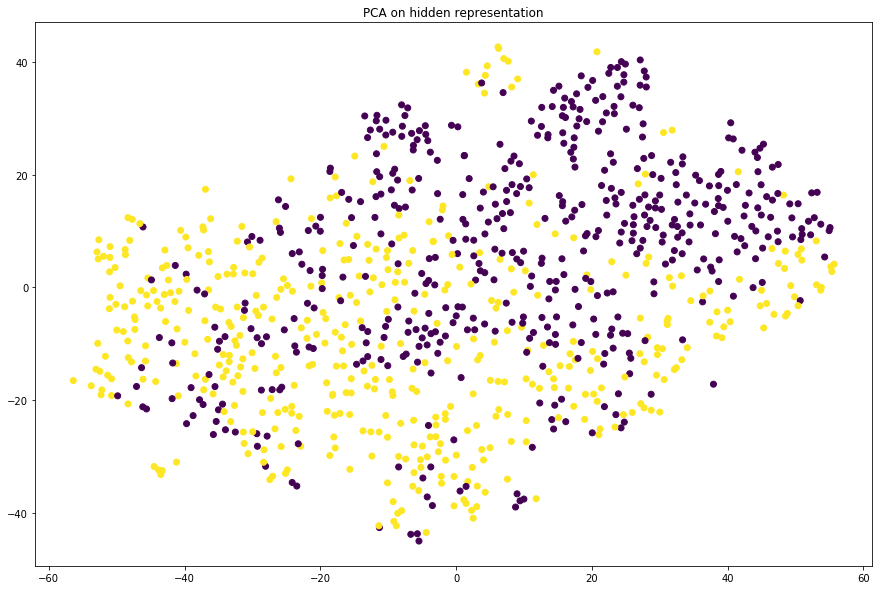

In [95]:
np.random.seed(42)
plot_tsne_hidden_conv(model, train_loader, device, input_dim, 'PCA on hidden representation', 972, -1)

Up until now, the only <i>response</i> of your training procedure were plain <i>numbers</i>. But as you dealing with <i>generative models</i>, actually <i>seeing</i> some of the results might be the <i>actual</i> goal you are aiming for. Therefore, your <b>third</b> and <b>last</b> task of this exercise is defined as:

- Save the <i>decoded</i> latent representation to <code>./samples/vae_random_sample.png</code> (keep in mind to <i>reshape</i> the tensor of the <i>color</i> image accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the <i>lecture</i>).

Do you like what you see? In either case comment on the <i>result</i> and discuss <i>possible</i> shortcomings of <i>variational autoencoders</i> (e.g. with respect to the <i>sharpness</i> of the generated images) and possible <i>pre-processing</i> steps of the data set which might <i>improve</i> the overall model performance.

In [107]:
sample_random = Variable(torch.randn(args.batch_size, settings.hidden_channels)).to(device)
output = model.decode(sample_random).to(device)
u7.save_image(output.view(args.batch_size, 3, 32, 32),
               './samples/vae_random_sample.png')

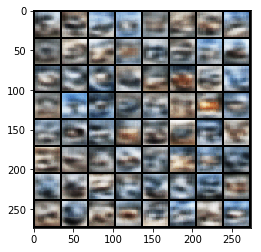

In [108]:
img_vae_random = mpimg.imread('./samples/vae_random_sample.png')
plt.imshow(img_vae_random)

# Answer
In general, the result is not that bad (one can recognize certain objects), but not very good, either. Mainly the images are blurred. I think one reason for this is that the images are not black and white, but in color (3 channels). Therefore, the CIFAR10 dataset has more features and is a more complex set. As a result, finding a good neural network which then generates good images is relatively harder. One solution could be to make the model itself more complex (e.g. add more convolutional layers). Another way to fix the color problem would be to remove 2 of the 3 color channels and with that change the dataset to black-and-white during preprocessing.

Another reason for the blurriness could be that VAEs are usually using a small latent dimension, therefore much information is lost when passing the information through the bottleneck. 

In the internet I found out that another possible cause for the blurriness could be the loss function of the VAE which "usually penalizes putting a feature in the wrong spot worse than it penalizes blurring out or entirely skipping over that feature".

# Exercise 3
<font color='darkred'><i>Note: the tasks of this exercise will consume <b>a lot</b> of computational resources, and thus will take some time to complete (most probably $\gt 20min$). This is especially the case if <b>no</b> NVIDIA GPU is available. As the final quality of the generated images is highly dependent on the available resources and time spent training the networks, your final points of this exercise will <b>not</b> depend on the image quality but on correctness of the implementation and interpretation of the results.</i></font>

Before delving into the <i>depths</i> of <i>generative adversarial networks (GANs)</i>, a different data set needs to be loaded, as <i>CIFAR10</i> is a little bit too complex for this exercise. The data set of choice should already look familiar to you:

<cite>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747</cite>

Moreover, perform the following steps prior to satisfying your curiosity about <i>generative adversarial networks</i> on the data:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Load the <i>Fashion-MNIST</i> data set (returns the <i>training</i> as well as the <i>test</i> set data loader).
- Display the first <i>36</i> images of the <i>Fashion-MNIST</i> data set.

Can you identify possible <i>labels</i> of the displayed images? As you already know the data set inside out, do you observe any <i>differences</i> compared to e.g. the previous assignment?

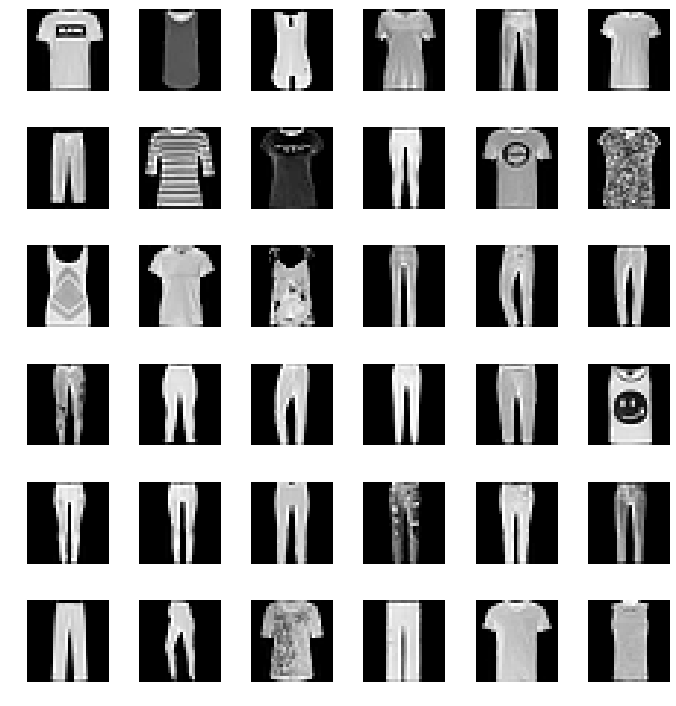

In [90]:
torch.manual_seed(42)
train_loader_mnist, test_loader_mnist = u7.get_FashionMNIST_data(args, use_cuda)

u7.display_FashionMNIST(train_loader_mnist, 36)

# Answer
## Possible labels
- t-shirt (images 1, 4, 6, 8, 9, 11, 12, 14, 24, 33, 35)
- pants (images 5, 7, 10, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 2, 29, 30, 31, 32, 34)
- dress (2, 3, 13, 15, 36)

## differences
- There are no shoes.
- It seems like some images are more detailed (e.g. t-shirts with an imprint). 

In order to define <i>generative adversarial network</i> for further processing of the data set (and hopefully generating <i>beautiful</i> images), some minimal knowledge about the <i>structure</i> of the images is required:

- Find out the <i>input dimensionality</i> of the data set.

Keep in mind, that the images of the current data set are <i>less</i> colorful.

In [106]:
train_image_zero, train_target_zero = train_loader.dataset[0]
input_dim_mnist = train_image_zero.shape[1] * train_image_zero.shape[2]
print("The input dimensionality is", input_dim_mnist)

The input dimensionality is 1024


After loading and briefly analyzing the Fashion-MNIST data set, you are now getting your hands dirty with <i>generative adversarial networks</i>. So your <b>first</b> task of this exercise is to combine both methods, <i>generative adversarial networks</i> and <i>convolutional neural networks</i>. Thus, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters and further members accordingly $\ldots$

$\ldots$ for the <i>generator</i> network:
- <code>input_channels = 32</code>
- <code>projection_channels = 48</code>
- <code>input_kernel_size = 4</code>
- <code>input_stride = 1</code>
- <code>generator_channels = 64</code>
- <code>generator_kernel_size = 2</code>
- <code>generator_stride = 2</code>
- <code>hidden_dimensionality = 28</code>
- <code>hidden_channels = 1</code>

$\ldots$ for the <i>discriminator</i> network:
- <code>hidden_projection_channels = 48</code>
- <code>hidden_kernel_size = 4</code>
- <code>hidden_stride = 1</code>
- <code>hidden_pool_kernel_size = 4</code>
- <code>hidden_pool_stride = 2</code>
- <code>discriminator_channels = 32</code>
- <code>discriminator_kernel_size = 4</code>
- <code>discriminator_stride = 2</code>
- <code>discriminator_pool_kernel_size = 4</code>
- <code>discriminator_pool_stride = 2</code>

Further fields like <code>batch_size</code> or <code>weight_decay</code> can be reused from <b>Exercise 1</b>.

In [297]:
settings_gan = SimpleNamespace(
    
    # Settings of the generator network.
    input_channels=1024, projection_channels=512, input_kernel_size=5, input_stride=1,
    generator_channels=256, generator_kernel_size=4, generator_stride=2, generator_padding=1,
    convadd1_channels=1, convadd1_kernel_size=4, convadd1_stride=2, convadd1_padding=1,
    hidden_dimensionality=28, hidden_channels=1, z_dim=100,
    
    # Settings of the discriminator network.
    hidden_projection_channels=48, hidden_kernel_size=4, hidden_stride=1,
    hidden_pool_kernel_size=3, hidden_pool_stride=2,
    discriminator_channels=64, discriminator_kernel_size=4, discriminator_stride=2,
    discriminator_pool_kernel_size=4, discriminator_pool_stride=2
)

On the basis of the <i>convolutional neural network</i> and <i>generative adversarial network</i> implementations of the lecture, construct a <i>convolutional generative adversarial network</i> using the <i>settings</i> defined up above and the following attributes (to get you started, later on you are encouraged to modify some of these settings in order to get more interesting results, but keep in mind, that <i>recklessly</i> setting some hyperparameters to <i>big</i> numbers most probably leads to <i>enormous</i> runtimes) for $\ldots$

$\ldots$ the <i>generator</i> network:
- One <i>upconvolution</i> layer, accepting random inputs of size $1 \times 1$ with channels as defined previously.
- One <i>upconvolution</i> layer defined by <code>generator_*</code> attributes on top of the previous <i>upconvolution</i> layer.
- One <i>dense</i> generator layer, projecting to the <i>target</i> space of the Fashion-MNIST images.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the generator output).


$\ldots$ the <i>discriminator</i> network:
- One <i>convolutional</i> input layer, accepting images of the <i>Fashion-MNIST</i> data set.
- One <i>max pooling</i> layer, operating on the result of the <i>input</i> layer.
- One <i>convolutional</i> hidden layer, with an output dimensionality as defined previously.
- One <i>max pooling</i> layer, operating on the result of the <i>hidden</i> layer.
- One <i>dense</i> discriminator layer, with a dimensionality suited for <i>binary</i> classification.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the discriminator output).

To summarize your <b>second task</b> of this exercise:

- Implement a <i>Python class</i> <code>ConvolutionalGenerator</code> as discussed during the lexture.
- Implement a <i>Python class</i> <code>ConvolutionalDiscriminator</code> as discussed during the lexture.
- Implement a <i>utility Python class</i> <code>Inflate</code>, which acts as a negation to <code>Flatten</code>.

In [298]:
class Inflate(torch.nn.Module):
    
    def __init__(self, dimensionality: int, output_width: int, output_height: int):
        super(Inflate, self).__init__()
        self.__dimensionality = dimensionality
        self.output_width = output_width
        self.output_height = output_height
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.view(x.size(0), self.__dimensionality, self.output_width, self.output_height)
    
class ConvolutionalGenerator(torch.nn.Module):
    
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalGenerator, self).__init__()
        
        # Project from input space to hidden space of generator.
        
        self.project = torch.nn.Linear(settings_gan.z_dim, 1024*4*4)
        
        input_convolution = torch.nn.ConvTranspose2d(settings_gan.input_channels, 
                                                     settings_gan.projection_channels, 
                                                     settings_gan.input_kernel_size, 
                                                     stride=settings_gan.input_stride)
        
        generator_convolution = torch.nn.ConvTranspose2d(settings_gan.projection_channels,
                                                        settings_gan.generator_channels,
                                                        settings_gan.generator_kernel_size,
                                                        stride=settings_gan.generator_stride)
        
        conv_add_1 = torch.nn.ConvTranspose2d(settings_gan.generator_channels,
                                              settings_gan.convadd1_channels,
                                             settings_gan.convadd1_kernel_size,
                                             stride=settings_gan.convadd1_stride,
                                             padding=settings_gan.convadd1_padding)
        
        # Combine the generator.
        self.generator = torch.nn.Sequential(
            input_convolution, torch.nn.ReLU(), generator_convolution, torch.nn.ReLU(),
            conv_add_1, torch.nn.Tanh())
    
    """
    @staticmethod
    def _compute_upconvolution_size(size: int, padding: int, output_padding: int,
                                    dilation: int, kernel_size: int, stride: int) -> int:
        
        #---------------------------------------#
        #               YOUR CODE               #
        #---------------------------------------#
    """
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.project(x)
        x = x.view(x.size(0), 1024, 4, 4)
        x = self.generator(x)
        return x

    settings_gan = SimpleNamespace(
    
    # Settings of the generator network.
    input_channels=1024, projection_channels=512, input_kernel_size=5, input_stride=1,
    generator_channels=256, generator_kernel_size=4, generator_stride=2, generator_padding=1,
    convadd1_channels=1, convadd1_kernel_size=4, convadd1_stride=2, convadd1_padding=1,
    hidden_dimensionality=28, hidden_channels=1, z_dim=100,
    
    # Settings of the discriminator network.
    hidden_projection_channels=48, hidden_kernel_size=4, hidden_stride=1,
    hidden_pool_kernel_size=3, hidden_pool_stride=2,
    discriminator_channels=32, discriminator_kernel_size=4, discriminator_stride=2,
    discriminator_pool_kernel_size=4, discriminator_pool_stride=2
)
    
class ConvolutionalDiscriminator(torch.nn.Module):
    
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalDiscriminator, self).__init__()
        
        # Project from the hidden space to the output space of the discriminator.        
        
        hidden_input_convolution = torch.nn.Conv2d(1, settings_gan.hidden_projection_channels,
                                                  settings_gan.hidden_kernel_size, 
                                                   stride=settings_gan.hidden_stride)
        
        hidden_pool = torch.nn.MaxPool2d(settings_gan.hidden_pool_kernel_size, settings_gan.hidden_pool_stride)
        
        discriminator_convolution = torch.nn.Conv2d(settings_gan.hidden_projection_channels, 
                                                    settings_gan.discriminator_channels,
                                                   settings_gan.discriminator_kernel_size,
                                                   stride=settings_gan.discriminator_stride)
        
        discriminator_pool = torch.nn.MaxPool2d(settings_gan.discriminator_pool_kernel_size, 
                                                settings_gan.discriminator_pool_stride)
        
        output_projection = torch.nn.Linear(64*2*2, 1)
        
        # Combine the discriminator.
        self.discriminator = torch.nn.Sequential(
            hidden_input_convolution, torch.nn.ReLU(), hidden_pool,
            discriminator_convolution, torch.nn.ReLU(), discriminator_pool,
            torch.nn.Flatten(), output_projection, torch.nn.Sigmoid())
    
    @staticmethod
    def _compute_convolution_size(size: int, padding: int, dilation: int,
                                  kernel_size: int, stride: int) -> int:
        
        kernel_size_dilated = dilation * (kernel_size + 1) - 1
        output_size = ((size - kernel_size_dilated + 2 * padding) / stride) + 1
        return int(output_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.size()) != 4:
            x = x.view(x.size(0), 1, 32, 32)
        x = self.discriminator(x)
        return x

Train the previously defined <i>convolutional generative adversarial network</i> model by applying the corresponding <i>data loader</i> (keep in mind for which data set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>. 

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.

Report the performance on the <i>test set</i> afterwards. Moreover, experiment with different hyperparameter settings, for instance set different values for $\ldots$

- $\ldots$ the learning rate <code>lr</code>.
- $\ldots$ the depth of the random input vector <code>input_channels</code>.
- $\ldots$ the size of the input kernel <code>input_kernel_size</code>.

Do you notice any differences? With respect to runtime, which <i>settings</i> had a small/big impact? Try to argue about <i>possible</i> reasons.

In [299]:
torch.manual_seed(42)

G = ConvolutionalGenerator(settings_gan).to(device)
D = ConvolutionalDiscriminator(settings_gan).to(device)

# loss
criterion = torch.nn.BCELoss()
 
G_optimizer = u7.optim.Adam(G.parameters(), lr = args.lr)
D_optimizer = u7.optim.Adam(D.parameters(), lr = args.lr)

In [301]:
z_latent = 100
for epoch in range(1, args.epochs+1):           
    D_losses, G_losses = [], []
    n = 0
    for x, _ in train_loader_mnist:
        D_losses.append(u7.train_discriminator(x, D, G, input_dim_mnist, args.batch_size, criterion, z_latent, D_optimizer, device))
        G_losses.append(u7.train_generator(D, G, args.batch_size, criterion, z_latent, G_optimizer, device))
        n += 1
        print(n, "/157")

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), args.epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    with torch.no_grad():
        test_z = Variable(torch.randn(args.batch_size, z_latent).to(device))
        generated = G(test_z)
        u7.save_image(generated.view(generated.size(0), 1, 36, 36), os.path.join('.','samples','GAN_sample_{}.png'.format(epoch)))

print("Done")

1 /157
2 /157
3 /157
4 /157
5 /157
6 /157
7 /157
8 /157
9 /157
10 /157
11 /157
12 /157
13 /157
14 /157
15 /157
16 /157
17 /157
18 /157
19 /157
20 /157
21 /157
22 /157
23 /157
24 /157
25 /157
26 /157
27 /157
28 /157
29 /157
30 /157
31 /157
32 /157
33 /157
34 /157
35 /157
36 /157
37 /157
38 /157
39 /157
40 /157
41 /157
42 /157
43 /157
44 /157
45 /157
46 /157
47 /157
48 /157
49 /157
50 /157
51 /157
52 /157
53 /157
54 /157
55 /157
56 /157
57 /157
58 /157
59 /157
60 /157
61 /157
62 /157
63 /157
64 /157
65 /157
66 /157
67 /157
68 /157
69 /157
70 /157
71 /157
72 /157
73 /157
74 /157
75 /157
76 /157
77 /157
78 /157
79 /157
80 /157
81 /157
82 /157
83 /157
84 /157
85 /157
86 /157
87 /157
88 /157
89 /157
90 /157
91 /157
92 /157
93 /157
94 /157
95 /157
96 /157
97 /157
98 /157
99 /157
100 /157
101 /157
102 /157
103 /157
104 /157
105 /157
106 /157
107 /157
108 /157
109 /157
110 /157
111 /157
112 /157
113 /157
114 /157
115 /157
116 /157
117 /157
118 /157
119 /157
120 /157
121 /157
122 /157
123 /157
1

RuntimeError: shape '[-1, 1024]' is invalid for input of size 25088

# "Answer"
Unfortunately, my laptop took very, <b>very</b> long to train the GAN. Therefore, I didn't try out different settings.

Moreover I didn't quite implement the GAN like you asked us to. The reason for this is that I didn't understand certain parts (e.g. why we need a "dense generator layer, projecting to the target space of the Fashion-MNIST images" and how to implement it). I got some help from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html and oriented myself there.

As with the <i>convolutional variational autoencoder</i> of the previous exercise, the <i>actual</i> goal of such a method might be to generate interesting images. To verify (or <i>disconfirm</i>) the <i>generative power</i> of your <i>convolutional generative adversarial network</i>, your <b>third</b> and <b>last</b> task of this exercise is defined as:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Save the <i>decoded</i> latent representation to <code>./samples/gan_random_sample.png</code> (keep in mind to <i>reshape</i> the tensor of the <i>colorless</i> image accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the <i>lecture</i>).

Do you like what you see? In either case comment on the <i>result</i> and discuss <i>possible</i> shortcomings of <i>(vanilla) generative adversarial networks</i> (e.g. with respect to the <i>diversity</i> of the generated images) and possible <i>pre-processing</i> steps of the data set which might <i>improve</i> the overall model performance.

In [275]:
torch.manual_seed(42)

test_z = Variable(torch.randn(args.batch_size, z_latent).to(device))
generated = G(test_z)
u7.save_image(generated.view(generated.size(0), 1, 36, 36), os.path.join('.','samples','gan_random_sample.png'.format(epoch)))

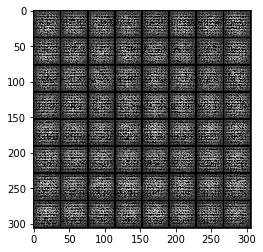

In [276]:
img_vae_random = mpimg.imread('./samples/gan_random_sample.png')
plt.imshow(img_vae_random)

# Answer
Unfortunately, my GAN doesn't work the way it should. The picture above was generated when accidentally using the false dataset (the CIFAR10). After that I changed to the right one and the error above occured.